# data simulation and augmentation

In [1]:
import os
import re
from scipy.signal import find_peaks, filtfilt, resample
import random
import pymatgen as mg
from scipy import signal
from pymatgen.analysis.diffraction import xrd
from skimage import restoration
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate as ip
from pymatgen.core import Structure
from pyts import metrics
import numpy as np
import warnings
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm 
from pymatgen.io.fleur import FleurInput
from spectrum_generation700 import strain_shifts, uniform_shifts, intensity_changes, peak_broadening, impurity_peaks, mixed
import multiprocessing
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
from ase.io import read

In [2]:
class SpectraGenerator(object):
    """
    Class used to generate augmented xrd spectra
    for all reference phases
    """

    def __init__(self, reference_dir, num_spectra=10, max_texture=0.6, min_domain_size=1.0, max_domain_size=100.0, 
                 max_strain=0.01, max_shift=0.25, impur_amt=60.0, min_angle=10.0, max_angle=80.0, separate=True):
        """
        Args:
            reference_dir: path to directory containing
                CIFs associated with the reference phases
        """
        self.num_cpu = 50
        self.ref_dir = reference_dir
        self.num_spectra = num_spectra
        self.max_texture = max_texture
        self.min_domain_size = min_domain_size
        self.max_domain_size = max_domain_size
        self.max_strain = max_strain
        self.max_shift = max_shift
        self.impur_amt = impur_amt
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.separate = separate

    def augment(self, phase_info):
        """
        For a given phase, produce a list of augmented XRD spectra.
        By default, 50 spectra are generated per artifact, including
        peak shifts (strain), peak intensity change (texture), and
        peak broadening (small domain size).

        Args:
            phase_info: a list containing the pymatgen structure object
                and filename of that structure respectively.
        Returns:
            patterns: augmented XRD spectra
            filename: filename of the reference phase
        """

        struc, filename = phase_info[0], phase_info[1]
        patterns = []

        if self.separate:
            patterns += strain_shifts.main(struc, self.num_spectra, self.max_strain, self.min_angle, self.max_angle)
            patterns += uniform_shifts.main(struc, self.num_spectra, self.max_shift, self.min_angle, self.max_angle)
            patterns += peak_broadening.main(struc, self.num_spectra, self.min_domain_size, self.max_domain_size, self.min_angle, self.max_angle)
            patterns += intensity_changes.main(struc, self.num_spectra, self.max_texture, self.min_angle, self.max_angle)
            patterns += impurity_peaks.main(struc, self.num_spectra, self.impur_amt, self.min_angle, self.max_angle)
        else:
            patterns += mixed.main(struc, 5*self.num_spectra, self.max_shift, self.max_strain, self.min_domain_size, self.max_domain_size,  self.max_texture, self.impur_amt, self.min_angle, self.max_angle)

        return (patterns, filename)

    @property
    def augmented_spectra(self):

        phases = []
        for filename in sorted(os.listdir(self.ref_dir)):
            phases.append([Structure.from_file('%s/%s' % (self.ref_dir, filename)), filename])

        with Manager() as manager:

            pool = Pool(self.num_cpu)
            grouped_xrd = pool.map(self.augment, phases)
            sorted_xrd = sorted(grouped_xrd, key=lambda x: x[1]) ## Sort by filename
            sorted_spectra = [group[0] for group in sorted_xrd]

            return np.array(sorted_spectra)

    
    def process_cif_file(self, cif_filename):
        cif_name = os.path.splitext(cif_filename)[0]

        try:
            for i in range(len(self.augmented_spectra)):
                for j in range(len(self.augmented_spectra[i])):
                    enhanced_spectrum = self.augmented_spectra[i, j]

                    # Extract "CollCode" number and use it in spectrum_name
                    collcode_match = re.search(r'CollCode(\d+)', cif_name)
                    collcode = collcode_match.group(1) if collcode_match else ""

                    spectrum_name = f"CollCode{collcode}_enhanced{j+1}"
                    spectrum_filename = os.path.join(spectras_folder, f"{spectrum_name}.csv")

                    np.savetxt(spectrum_filename, enhanced_spectrum.squeeze(), delimiter='\t')
                    print(f"Saved spectrum: {spectrum_filename}")

        except Exception as e:
            print(f"Error processing CIF file: {cif_filename} - {e}")
            problematic_files.append(cif_filename)


In [3]:
num_spectra = 1
max_texture = 0.76
min_domain_size = 1.0
max_domain_size = 100.0
max_strain = 0.05
max_shift = 1
impur_amt = 60.0
min_angle = 10.0
max_angle = 80.0
separate = True

# 设置文件路径和保存路径
cifs_folder = "/home/rongchang/Demo/93/"
ref_dir = "./References/"
spectras_folder = "/home/rongchang/Demo/93_theo_xrd/"
if not os.path.exists(spectras_folder):
    os.makedirs(spectras_folder)

# 循环处理每个cif文件
xrd_obj = SpectraGenerator(cifs_folder, num_spectra, max_texture, min_domain_size, max_domain_size,
                           max_strain, max_shift, impur_amt, min_angle, max_angle, separate)
sorted_spectra = xrd_obj.augmented_spectra


# Initialize the tqdm progress bar for the loop
for i in tqdm(range(len(sorted_spectra)), desc="Processing CIF Files"):
    cif_filename = sorted(os.listdir(cifs_folder))[i]
    cif_name = os.path.splitext(cif_filename)[0]

    for j in range(len(sorted_spectra[i])):
        enhanced_spectrum = sorted_spectra[i, j]
        spectrum_name = f"{cif_name}_enhanced{j+1}"
        spectrum_filename = os.path.join(spectras_folder, f"{spectrum_name}.csv")

        np.savetxt(spectrum_filename, enhanced_spectrum.squeeze(), delimiter='\t')
        print(f"Saved spectrum: {spectrum_filename}")

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 5 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/site-packages/pymatgen/io/cif.py:1225: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/rongchang/.conda/envs/rongchang/lib/python3.9/sit

Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-1_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-1_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-1_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-1_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-1_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-11_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-11_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-11_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-11_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-11_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-114_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-114_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-114_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-114_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/

Processing CIF Files:  53%|████████████████████████████████▋                             | 49/93 [00:00<00:00, 161.13it/s]

Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-179_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-179_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-179_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-179_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-182_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-182_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-182_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-182_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-182_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-185_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-185_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-185_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-185_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-185_enhanced5.csv
Saved spectrum: /home/rongchang/De

Processing CIF Files: 100%|██████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 160.87it/s]

Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-47_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-5_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-5_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-5_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-5_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-5_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-51_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-51_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-51_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-51_enhanced4.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-51_enhanced5.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-52_enhanced1.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-52_enhanced2.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-52_enhanced3.csv
Saved spectrum: /home/rongchang/Demo/93_theo_xrd/1-52

In [4]:
import csv

# 原始文件夹路径
folder_path = "./93_theo_xrd/"

new_file_path = "./93theoXRD.csv"

# 获取文件夹中的所有CSV文件
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# 准备第一行的数据
header = ["Sample"] + [f"{i/10:.1f}" for i in range(101, 801)] + ["Space Group"]

# 打开新的CSV文件以写入数据 
with open(new_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # 写入第一行的数据
    writer.writerow(header)

    # 遍历每个CSV文件并读取内容
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)

        # 使用正则表达式从文件名中提取标签
        label_match = re.search(r'-(\d+)_', csv_file)
        if label_match:
            label = label_match.group(1)  # 提取匹配到的数字作为标签
        else:
            label = ""

        # 读取CSV文件内容并写入新的CSV文件
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            column_data = [row[0] for row in reader]  # 获取每个CSV文件的第一列数据作为行数据

            sample_name = os.path.splitext(csv_file)[0]  # 获取样本名，去掉文件扩展名
            data_row = [sample_name] + column_data + [label]
            writer.writerow(data_row)

print("data have been saved.")


data have been saved.


# data synthesis

In [5]:
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
from glob import glob
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
random.seed(0)

if not os.path.exists('temp'):
    os.mkdir('temp')

In [6]:
def DataSynthesis(i, Ts, Es):
    synthetic_data = []
    for j in range(Es.shape[0]):
        e = random.uniform(0, 1)
        T = Ts.values[i, 1:-1]
        if Es.values[j, -1] != Ts.values[i, -1]:
            continue
        else:
            E = Es.values[j, 1:-1]
            last_column = Es.values[j, -1]
            Xac = [E_val + e * T_val for E_val, T_val in zip(E, T)]
            max_value = max(Xac)
            min_value = min(Xac)
            scaled_Xac = [100 * (X_val - min_value) / (max_value - min_value) if i < len(Xac) - 1 else X_val for i, X_val in enumerate(Xac)]
            scaled_Xac.append(last_column)
            synthetic_data.append(np.array(scaled_Xac))

    if synthetic_data:
        columns = list(Es.columns[1:-1]) + [Es.columns[-1]]
        df = pd.DataFrame(np.array(synthetic_data), columns=columns)
        df.to_csv('temp/{}.csv'.format(i), index=False)
        
    else:
        print("No data for index {}".format(i))

In [7]:
Ts = pd.read_csv("./93theoXRD.csv")
Es = pd.read_csv('./exp_xrd_0.8.csv')


desired_synthetic_data_count = 378
synthetic_data = pd.DataFrame([])
simu_df_sample = Ts.sample(desired_synthetic_data_count, random_state=0)

# Parallel processing
with Pool(64) as p:
    p.starmap(DataSynthesis, [(i, Ts, Es) for i in simu_df_sample.index])

for file in glob('temp/*.csv'):
    synthetic_data = pd.concat([synthetic_data, pd.read_csv(file)], axis=0)

print(f"Progress: {len(synthetic_data)} data points (Finished)")

# 将合成的数据保存到新的CSV文件
synthetic_data = synthetic_data.reset_index(drop=True)
synthetic_data.reset_index(drop=True).to_csv('./93_syn_data0.8.csv', index=False)

No data for index 1
No data for index 379
No data for index 318
No data for index 224
No data for index 124
No data for index 461
No data for index 10
No data for index 96
No data for index 170
No data for index 347
No data for index 240
No data for index 164
No data for index 430
No data for index 276
No data for index 345
No data for index 160
No data for index 206
No data for index 12
No data for index 315
No data for index 122
No data for index 434
No data for index 420
No data for index 426
No data for index 220
No data for index 346
No data for index 450
No data for index 75
No data for index 375
No data for index 142
No data for index 175
No data for index 309
No data for index 348
No data for index 351
No data for index 52No data for index 422

No data for index 6
No data for index 4No data for index 441

No data for index 26
No data for index 281
No data for index 76
No data for index 454
No data for index 416
No data for index 241
No data for index 343
No data for index 246
N

# classification

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split, ConcatDataset, TensorDataset
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import math
from torch.nn import Parameter
import torch.distributions as dist
import torchbnn as bnn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [3]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = Parameter(torch.Tensor(out_features))
        self.bias_rho = Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_mu, a=math.sqrt(5))
        nn.init.constant_(self.bias_mu, 0)
        nn.init.constant_(self.weight_rho, -5)
        nn.init.constant_(self.bias_rho, -5)

    def forward(self, x):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        epsilon_weight = torch.randn_like(weight_sigma)
        epsilon_bias = torch.randn_like(bias_sigma)
        weight = self.weight_mu + weight_sigma * epsilon_weight
        bias = self.bias_mu + bias_sigma * epsilon_bias
        
        return F.linear(x, weight, bias)
    
    def kl_divergence(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))

        weight_prior = dist.Normal(0, 1)
        bias_prior = dist.Normal(0, 1)

        weight_posterior = dist.Normal(self.weight_mu, weight_sigma)
        bias_posterior = dist.Normal(self.bias_mu, bias_sigma)

        kl_weight = torch.distributions.kl.kl_divergence(weight_posterior, weight_prior).sum()
        kl_bias = torch.distributions.kl.kl_divergence(bias_posterior, bias_prior).sum()

        return kl_weight + kl_bias

class BayesianVGGNet(nn.Module):
    def __init__(self, n_classes, conv1_out, conv2_out, fc1_out, input_length):
        super(BayesianVGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, conv1_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(conv1_out, conv1_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(conv1_out, conv2_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(conv2_out, conv2_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(conv2_out, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Calculate the flattened input size for the first fully connected layer
        self.flattened_input_size = self._get_flattened_input_size(input_length, conv1_out, conv2_out)

        self.classifier = nn.Sequential(
            BayesianLinear(self.flattened_input_size, fc1_out),
            nn.ReLU(),
            BayesianLinear(fc1_out, n_classes)
        )

    def _get_flattened_input_size(self, input_length, conv1_out, conv2_out):
        # Pass a dummy tensor through the feature extractor to determine the flattened size
        dummy_input = torch.zeros(1, 1, input_length)
        dummy_output = self.features(dummy_input)
        flattened_input_size = dummy_output.view(1, -1).size(1)  # 将 flattened_input_size 计算为每个样本的特征数量
        return dummy_output.view(-1).size(0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

    def kl_divergence(self):
        kl = 0.0
        for module in self.classifier:
            if isinstance(module, BayesianLinear):
                kl += module.kl_divergence()
        return kl


In [4]:
# Training and validation functions
def train_epoch(model, dataloader, optimizer, kl_weight):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        inputs = inputs.unsqueeze(1)  # Add an extra dimension for the channel
        targets = targets.long()  # Convert targets to long data type
        
        optimizer.zero_grad()
        outputs = model(inputs)
        classification_loss = nn.CrossEntropyLoss()(outputs, targets)
        kl_div = model.kl_divergence()
        loss = classification_loss + kl_weight * kl_div
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += inputs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def validate_epoch(model, dataloader, kl_weight):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            inputs = inputs.unsqueeze(1)  # Add an extra dimension for the channel
            targets = targets.long()  # Convert targets to long data type   
                     
            outputs = model(inputs)
            classification_loss = nn.CrossEntropyLoss()(outputs, targets)
            kl_div = model.kl_divergence()
            loss = classification_loss + kl_weight * kl_div
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [5]:
def compute_entropy_and_predictions(model, dataloader, num_samples=100):
    model.eval()
    all_entropies = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(DEVICE)
            inputs = inputs.unsqueeze(1)  # Add an extra dimension for the channel
            
            predictions = []
            for _ in range(num_samples):
                outputs = F.softmax(model(inputs), dim=1)
                predictions.append(outputs.cpu().numpy())
            
            predictions = np.array(predictions)
            mean_predictions = np.mean(predictions, axis=0)
            
            # Compute entropy
            entropies = -np.sum(mean_predictions * np.log(mean_predictions + 1e-10), axis=1)
            
            all_entropies.extend(entropies)
            all_predictions.extend(mean_predictions)
            all_targets.extend(targets.numpy())
    
    return np.array(all_entropies), np.array(all_predictions), np.array(all_targets)

def erfinv(x):
    """逆误差函数（erfinv）的近似计算"""
    a = 0.147
    term1 = np.log(1 - x ** 2) / 2
    term2 = np.log(1 - x ** 2) / a
    term3 = 4 / np.pi + term2 / 2
    return np.sign(x) * np.sqrt(np.sqrt(term3 ** 2 - term1) - term2)

def save_prediction_probabilities(prediction_probs, targets, save_path='results1/prediction_probabilities.csv'):
    # Ensure prediction_probs is a NumPy array or torch tensor
    if isinstance(prediction_probs, list):
        prediction_probs = np.array(prediction_probs)
    
    data = []
    for i, prob in enumerate(prediction_probs):
        label = targets[i]
        # Convert prob to a list if it's a numpy array or torch tensor
        data.append([label] + prob.tolist() if isinstance(prob, (np.ndarray, torch.Tensor)) else prob)
    
    columns = ['label'] + [f'prob_class_{i}' for i in range(len(prediction_probs[0]))]
    df = pd.DataFrame(data, columns=columns)
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_csv(save_path, index=False)

In [6]:
# Load synthetic data
synthetic_data = pd.read_csv("./syn_data0.8.csv")
synthetic_x = synthetic_data.iloc[:, :-1].values
synthetic_y = synthetic_data.iloc[:, -1].values

# Convert to PyTorch tensors
synthetic_x = torch.tensor(synthetic_x, dtype=torch.float32)
synthetic_y = torch.tensor(synthetic_y, dtype=torch.float32)

# Load experimental data 1 (exp_x1)
exp_data1 = pd.read_csv("./exp_xrd_0.2_1.csv")
exp_x1 = exp_data1.iloc[:, 1:-1].values
exp_y1 = exp_data1.iloc[:, -1].values

# Convert to PyTorch tensors
exp_x1 = torch.tensor(exp_x1, dtype=torch.float32)
exp_y1 = torch.tensor(exp_y1, dtype=torch.float32)

# Load experimental data 2 (exp_x2)
exp_data2 = pd.read_csv("./exp_xrd_0.2_2.csv")
exp_x2 = exp_data2.iloc[:, 1:-1].values
exp_y2 = exp_data2.iloc[:, -1].values

# Convert to PyTorch tensors
exp_x2 = torch.tensor(exp_x2, dtype=torch.float32)
exp_y2 = torch.tensor(exp_y2, dtype=torch.float32)


In [7]:
batch_size = 32
kl_weight = 1e-6  # Adjust as needed

# Separate synthetic and experimental data for two-stage training
train_dataset_synthetic = TensorDataset(synthetic_x, synthetic_y)
train_loader_synthetic = DataLoader(train_dataset_synthetic, batch_size=batch_size, shuffle=True)

train_dataset_exp = TensorDataset(exp_x1, exp_y1)
train_loader_exp = DataLoader(train_dataset_exp, batch_size=batch_size, shuffle=True)

# Prepare experimental data for testing
val_x = exp_x2
val_y = exp_y2
val_dataset = TensorDataset(val_x, val_y)

# Create DataLoader for testing set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

n_classes = 231
num_samples = 30

# Initialize lists to store results
results = {
    'train_losses': [],
    'train_accuracies': [],
    'val_losses': [],
    'val_accuracies': [],
    'epoch_list': [],
    'entropies': [],
    'predictions': [],
    'targets': []
}


# Update the architecture to the best one
best_architecture = {'conv1_out': 128, 'conv2_out': 128, 'fc1_out': 1024}

input_length = synthetic_x.shape[1]  # Assuming the input length is the same for all data
# Initialize best_val_acc and best_architecture here
best_val_acc = 0.0

# Initialize the model with the best architecture
model = BayesianVGGNet(n_classes=n_classes, input_length=input_length, **best_architecture).to(DEVICE)
n_epochs = 60

# Initialize optimizer and learning rate scheduler
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0, last_epoch=-1)

# Define a directory to save results
results_dir = "./results1/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)


# Initialize results dictionary
results = {
    'train_losses': [],
    'train_accuracies': [],
    'val_losses': [],
    'val_accuracies': [],
    'epoch_list': [],
    'entropies': [],
    'predictions': [],
    'targets': []
}

for epoch in range(n_epochs):
    # Train on synthetic data
    train_loss_synthetic, train_acc_synthetic = train_epoch(model, train_loader_synthetic, optimizer, kl_weight)
    print(f'Epoch {epoch+1}/{n_epochs} - Synthetic Data')
    print(f'Train Loss: {train_loss_synthetic:.4f} | Train Accuracy: {train_acc_synthetic:.4f}')

    # Train on experimental data
    train_loss_exp, train_acc_exp = train_epoch(model, train_loader_exp, optimizer, kl_weight)
    print(f'Epoch {epoch+1}/{n_epochs} - Experimental Data')
    print(f'Train Loss: {train_loss_exp:.4f} | Train Accuracy: {train_acc_exp:.4f}')

    # Validate on experimental data set 2
    val_loss, val_acc = validate_epoch(model, val_loader, kl_weight)
    print(f'Epoch {epoch+1}/{n_epochs} - Validation')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}')

    # Compute entropy and predictions
    entropies, predictions, targets = compute_entropy_and_predictions(model, val_loader)

    # Store results
    results['train_losses'].append(train_loss_exp)
    results['train_accuracies'].append(train_acc_exp)
    results['val_losses'].append(val_loss)
    results['val_accuracies'].append(val_acc)
    results['epoch_list'].append(epoch + 1)
    results['entropies'].append(entropies.tolist())
    results['predictions'].append(predictions.tolist())
    results['targets'].append(targets.tolist())

    # Update learning rate
    lr_scheduler.step()

    # Save intermediate results every 5 epochs
    if (epoch + 1) % 5 == 0:
        intermediate_results_path = os.path.join(results_dir, f'intermediate_results_epoch_{epoch+1}.json')
        with open(intermediate_results_path, 'w') as f:
            json.dump(results, f)
        print(f"Intermediate results saved to {intermediate_results_path}")

# Save final results to a JSON file
final_results_path = os.path.join(results_dir, 'final_training_results.json')
with open(final_results_path, 'w') as f:
    json.dump(results, f)

# Save model
model_path = os.path.join(results_dir, 'final_model.pt')
torch.save(model.state_dict(), model_path)

print(f"Training completed. Final results saved to {final_results_path}")
print(f"Final model saved to {model_path}")

# Save prediction probabilities
save_prediction_probabilities(results['predictions'][-1], results['targets'][-1], save_path='results1/prediction_probabilities.csv')
print(f"Prediction probabilities saved to results1/prediction_probabilities.csv")

Epoch 1/60 - Synthetic Data
Train Loss: 102.7739 | Train Accuracy: 0.9410
Epoch 1/60 - Experimental Data
Train Loss: 104.2964 | Train Accuracy: 0.4703
Epoch 1/60 - Validation
Val Loss: 103.8333 | Val Accuracy: 0.6031
Epoch 2/60 - Synthetic Data
Train Loss: 102.4281 | Train Accuracy: 0.9978
Epoch 2/60 - Experimental Data
Train Loss: 103.8001 | Train Accuracy: 0.5568
Epoch 2/60 - Validation
Val Loss: 103.8817 | Val Accuracy: 0.5155
Epoch 3/60 - Synthetic Data
Train Loss: 102.3066 | Train Accuracy: 0.9989
Epoch 3/60 - Experimental Data
Train Loss: 103.4254 | Train Accuracy: 0.6270
Epoch 3/60 - Validation
Val Loss: 103.4499 | Val Accuracy: 0.6237
Epoch 4/60 - Synthetic Data
Train Loss: 102.1876 | Train Accuracy: 0.9993
Epoch 4/60 - Experimental Data
Train Loss: 103.2039 | Train Accuracy: 0.6595
Epoch 4/60 - Validation
Val Loss: 103.2777 | Val Accuracy: 0.5928
Epoch 5/60 - Synthetic Data
Train Loss: 102.0692 | Train Accuracy: 0.9996
Epoch 5/60 - Experimental Data
Train Loss: 102.8685 | Trai

Epoch 36/60 - Validation
Val Loss: 100.6979 | Val Accuracy: 0.7268
Epoch 37/60 - Synthetic Data
Train Loss: 98.9510 | Train Accuracy: 1.0000
Epoch 37/60 - Experimental Data
Train Loss: 99.0164 | Train Accuracy: 0.9730
Epoch 37/60 - Validation
Val Loss: 100.5598 | Val Accuracy: 0.7629
Epoch 38/60 - Synthetic Data
Train Loss: 98.9510 | Train Accuracy: 1.0000
Epoch 38/60 - Experimental Data
Train Loss: 99.0732 | Train Accuracy: 0.9568
Epoch 38/60 - Validation
Val Loss: 100.4525 | Val Accuracy: 0.7371
Epoch 39/60 - Synthetic Data
Train Loss: 98.9510 | Train Accuracy: 1.0000
Epoch 39/60 - Experimental Data
Train Loss: 99.0401 | Train Accuracy: 0.9676
Epoch 39/60 - Validation
Val Loss: 100.5118 | Val Accuracy: 0.7784
Epoch 40/60 - Synthetic Data
Train Loss: 98.9510 | Train Accuracy: 1.0000
Epoch 40/60 - Experimental Data
Train Loss: 99.0241 | Train Accuracy: 0.9784
Epoch 40/60 - Validation
Val Loss: 100.3888 | Val Accuracy: 0.7577
Intermediate results saved to ./results1/intermediate_results

# Uncertainty

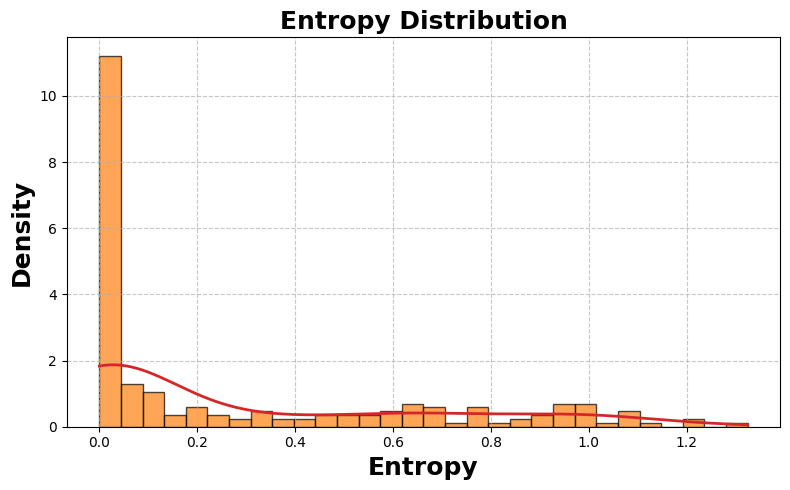

In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# 设置文件路径
results_dir = './results1/'
json_file = 'final_training_results.json'  # 最终的结果文件

# 读取 JSON 文件
file_path = os.path.join(results_dir, json_file)

with open(file_path, 'r') as f:
    data = json.load(f)

# 提取熵值数据
entropies = np.array(data['entropies'][-1])  # 最后一轮训练的熵值
predictions = np.array(data['predictions'][-1])  # 最后一轮训练的预测
targets = np.array(data['targets'][-1])  # 最后一轮训练的真实标签

# ***********************************
# 1. 绘制熵值分布图
# ***********************************

if len(entropies) == 0:
    print("No entropies data found!")
else:
    # 绘制熵值直方图和核密度估计曲线
    fig, ax = plt.subplots(figsize=(8, 5))

    # KDE 核密度估计
    kde = gaussian_kde(entropies)
    x_grid = np.linspace(entropies.min(), entropies.max(), 1000)

    # 绘制直方图，使用橙色
    ax.hist(entropies, bins=30, density=True, alpha=0.7, color='#ff7f0e', edgecolor='black')

    # 绘制密度曲线，使用深橙色
    ax.plot(x_grid, kde(x_grid), color='#d62728', linewidth=2)

    # 设置标签和标题
    ax.set_xlabel('Entropy', fontsize=18, fontweight='bold')
    ax.set_ylabel('Density', fontsize=18, fontweight='bold')
    ax.set_title('Entropy Distribution', fontsize=18, fontweight='bold')

    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.7)

    # 调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()


Class C2/c (Label 15) has 6 samples
Predicted probabilities for C2/c: [1.         0.99500138 0.99999994 0.99873662 0.69040877 0.99975258]
Class Cmcm (Label 63) has 1 samples
Predicted probabilities for Cmcm: [1.]
Class P4/mbm (Label 127) has 2 samples
Predicted probabilities for P4/mbm: [0.8045159  0.97998297]
Class Pm-3m (Label 221) has 15 samples
Predicted probabilities for Pm-3m: [0.99999982 0.99675989 0.99999803 0.99667966 0.99883461 0.99997109
 0.99622363 0.99759483 0.99998713 0.99953866 0.95439339 0.61278903
 0.99759483 0.99857187 0.98039567]
Standard deviations: [0.11490582986480226, 0.0, 0.08773353695869446, 0.09580502482164861]


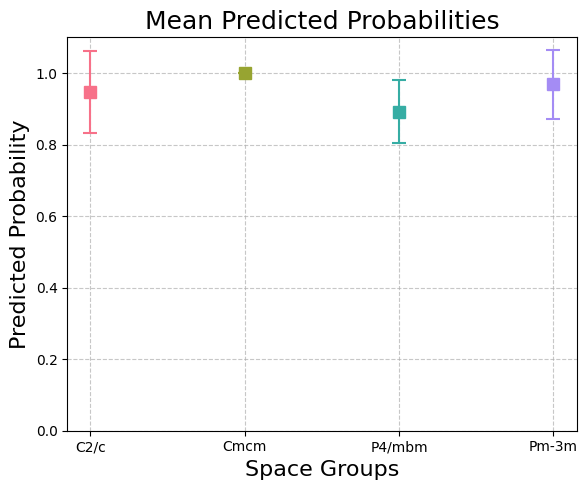

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 空间群字典
space_groups = {
    15: 'C2/c',
    63: 'Cmcm',
    127: 'P4/mbm',
    221: 'Pm-3m'
}

# 定义预测概率的阈值
threshold = 0.5

# 初始化用于存储每个空间群的预测均值和标准差
means = []
std_devs = []
labels = []

# 遍历空间群字典，处理每个指定的标签
for class_label, class_name in space_groups.items():
    
    # 获取该类别的预测概率
    predictions_for_class = predictions[:, class_label]

    # 筛选条件：真实标签为 `class_label` 且预测概率大于阈值
    mask = (targets == class_label) & (predictions_for_class > threshold)

    # 筛选出符合条件的样本
    filtered_predictions = predictions_for_class[mask]

    # 调试信息：打印样本的数量和预测概率
    print(f"Class {class_name} (Label {class_label}) has {len(filtered_predictions)} samples")
    print(f"Predicted probabilities for {class_name}: {filtered_predictions}")

    # 如果有符合条件的样本，计算均值和标准差
    if len(filtered_predictions) > 0:
        prediction_mean = np.mean(filtered_predictions)
        prediction_std = np.std(filtered_predictions)

        # 存储均值和标准差
        means.append(prediction_mean)
        std_devs.append(prediction_std)
        labels.append(class_name)
    else:
        print(f"No samples with true label {class_label} and predicted probability > {threshold}.")

# 调试信息：查看标准差
print(f"Standard deviations: {std_devs}")

# 绘制预测均值和标准差的误差棒图
fig, ax = plt.subplots(figsize=(6, 5))

# 定义颜色列表
colors = sns.color_palette("husl", len(means))

# 绘制误差棒，逐个为每个空间群指定颜色
for i in range(len(means)):
    ax.errorbar(labels[i], means[i], yerr=std_devs[i], fmt='s', capsize=5,
                markersize=8, color=colors[i], ecolor=colors[i], 
                elinewidth=1.5, capthick=1.5, linewidth=1.5)

# 设置标签和标题
ax.set_xlabel('Space Groups', fontsize=16)
ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_title('Mean Predicted Probabilities', fontsize=18)

# 设置y轴范围
ax.set_ylim(0, 1.1)

# 设置网格
ax.grid(True, linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# Interpretable analysis

<Figure size 1400x800 with 0 Axes>

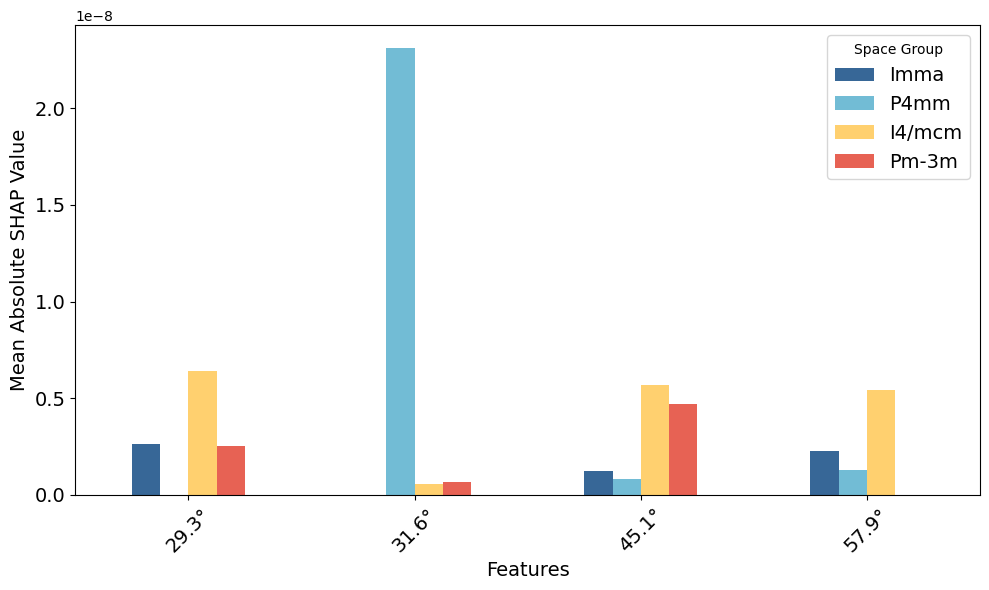

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the SHAP values from the CSV file
all_shap_values = pd.read_csv("./all_shap_values.csv")

# Map dataset identifiers to space groups
space_group_mapping = {
    '140': 'I4/mcm',
    '74': 'Imma',
    '99': 'P4mm',
    '221': 'Pm-3m'
}

# Filter relevant datasets
filtered_shap_values = all_shap_values[all_shap_values['dataset'].astype(str).isin(space_group_mapping.keys())]

# Define the columns corresponding to the angles you want to plot
angle_indices = [193, 216, 351, 479]  # Indices based on 20.3°, 22.7°, 31.3°, 57.6°

# Map the indices to their corresponding labels
angle_labels = ['29.3°', '31.6°', '45.1°', '57.9°']

# Extract relevant SHAP values
selected_shap_values = filtered_shap_values.iloc[:, angle_indices]

# Group by dataset and calculate mean absolute SHAP values
mean_shap_values = selected_shap_values.groupby(all_shap_values['dataset']).mean().abs()

# Apply the space group mapping
mean_shap_values.index = mean_shap_values.index.map(lambda x: space_group_mapping.get(str(x), 'Unknown'))

# Set column labels to the angle labels
mean_shap_values.columns = angle_labels

# Transpose for easier plotting
mean_shap_values = mean_shap_values.transpose()

# Plotting
plt.figure(figsize=(14, 8))
mean_shap_values.plot(kind='bar', figsize=(10, 6), color=["#376797", "#72BCD5", "#FFD06F", "#E76254"])
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.gca().tick_params(axis='both', which='minor', labelsize=14)
plt.ylabel('Mean Absolute SHAP Value', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.legend(title='Space Group', fontsize=14)
plt.tight_layout()

# Show plota
plt.show()